## Introduction ##

This is my first work of machine learning.

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

train = pd.read_csv('../input/train.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('../input/test.csv' , header = 0, dtype={'Age': np.float64})
full_data = [train, test]

print (train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


# Feature Engineering #

## 1. Pclass ##
there is no missing value on this feature and already a numerical value. so let's check it's impact on our train set.

In [2]:
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


## 2. Sex ##

In [3]:
print (train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


## 3. SibSp and Parch ##
With the number of siblings/spouse and the number of children/parents we can create new feature called Family Size.

In [4]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


it seems has a good effect on our prediction but let's go further and categorize people to check whether they are alone in this ship or not.

In [5]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


good! the impact is considerable.

## 4. Embarked ##
the embarked feature has some missing value. and we try to fill those with the most occurred value ( 'S' ).

In [6]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


## 5. Fare ##
Fare also has some missing value and we will replace it with the median. then we categorize it into 4 ranges.

In [7]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


## 6. Age ##
we have plenty of missing values in this feature. # generate random numbers between (mean - std) and (mean + std).
then we categorize age into 5 range.

In [8]:
for dataset in full_data:
    age_avg 	   = dataset['Age'].mean()
    age_std 	   = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)

print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.513761
1   (16.0, 32.0]  0.364653
2   (32.0, 48.0]  0.360784
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


## 7. Name ##
inside this feature we can find the title of people.

In [9]:
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))
print(train.head())

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   
3       Futrelle, Mrs. Jacques Heath (Lily

 so we have titles. let's categorize it and check the title impact on survival rate.

In [10]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


# Data Cleaning #
great! now let's clean our data and map our features into numerical values.

In [11]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

print (train.head(10))

train = train.values
test  = test.values


   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0         0       3    1    1     0         0        0      1
1         1       1    0    2     3         1        0      3
2         1       3    0    1     1         0        1      2
3         1       1    0    2     3         0        0      3
4         0       3    1    2     1         0        1      1
5         0       3    1    2     1         2        1      1
6         0       1    1    3     3         0        1      1
7         0       3    1    0     2         0        0      4
8         1       3    0    1     1         0        0      3
9         1       2    0    0     2         1        0      3


good! now we have a clean dataset and ready to predict. let's find which classifier works better on this dataset. 

# Classifier Comparison #

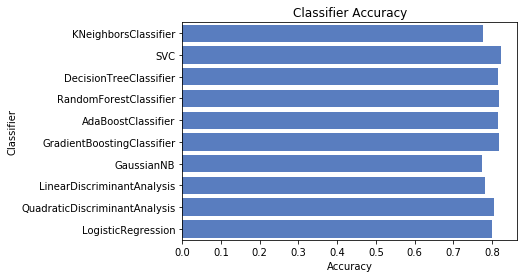

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True, gamma='scale'),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='lbfgs')]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [13]:
models = pd.DataFrame({
    'Model': list(acc_dict.keys()),
    'Score': list(acc_dict.values())}).sort_values(by='Score', ascending=False)
print(models)

                           Model     Score
1                            SVC  0.824444
5     GradientBoostingClassifier  0.817778
3         RandomForestClassifier  0.817778
2         DecisionTreeClassifier  0.816667
4             AdaBoostClassifier  0.815556
8  QuadraticDiscriminantAnalysis  0.806667
9             LogisticRegression  0.801111
7     LinearDiscriminantAnalysis  0.782222
0           KNeighborsClassifier  0.777778
6                     GaussianNB  0.775556


# Prediction #
now we can use SVC classifier to predict our data.

In [14]:
candidate_classifier = SVC(gamma='scale')
candidate_classifier.fit(train[0::, 1::], train[0::, 0])
result = candidate_classifier.predict(test)

submission = pd.DataFrame({
        "PassengerId": full_data[1]["PassengerId"],
        "Survived": result
    })
submission.to_csv('../output/sol2_submission.csv', index=False)
